# Question 7 | Implement a neural network using PyTorch

Generate a training dataset using the Python snippet given below. This snippet generates a spiral dataset consisting of K= 2 classes (purple and yellow crosses). The dataset is highly non-linear as can be seen in figure 2 below:




#### Generating the Data:

In [21]:
import numpy as np
np.random.seed(42)

def make_spiral(n_samples =100):
    # class 0
    t = 0.75 * np.pi * (1 + 3 * np.random.rand(1, n_samples ))
    x1 = t * np.cos(t)
    x2 = t * np.sin(t)
    y = np. zeros_like(t)

    # class 1
    t = 0.75 * np.pi * (1 + 3 * np.random.rand(1, n_samples ))
    x1 = np.hstack([-x1 , t * np.cos(t)])
    x2 = np.hstack([-x2 , t * np.sin(t)])
    y = np.hstack ([y, np.ones_like(t)])

    # concatenate data points for both classes
    X = np. concatenate ((x1 , x2 ))
    # add some noise
    X += 0.50 * np.random.randn(2, 2 * n_samples )

    return X.T, y[0]

# Generate the spiral dataset
X, y = make_spiral(n_samples=100)

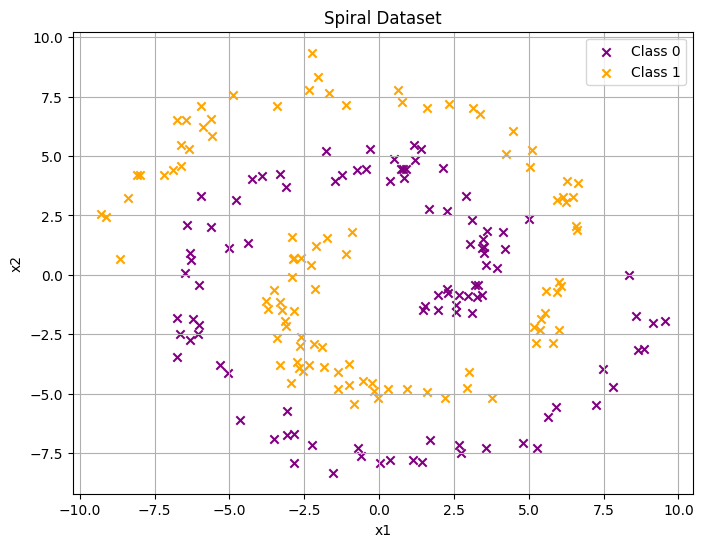

In [32]:
# Plotfunction
def plot_spiral(X, y):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='purple', label='Class 0', marker='x')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='orange', label='Class 1', marker='x')
    plt.title('Spiral Dataset')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid()
    plt.show()
# Plot the spiral dataset
plot_spiral(X, y)

In [31]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[-1.7769,  5.2217],
         [ 8.6473, -3.1784],
         [-2.2482, -7.1489],
         [-6.6416, -2.4775],
         [ 4.2191,  1.0704]]),
 tensor([0., 0., 0., 0., 0.]))

## Q1:
*Implement and train a neural network on the dataset generated above. You are free to use any network architecture you think is useful. Finally, plot the decision boundary generated by your model.*

- The training of a neural network can be devided into the following steps:
1. Initialization of the parameters W[1], b[1], W[2], b[2], . . .
2. Computation of the forward pass
(i. e. compute the activations of the network for a batch of training examples)
3. Evaluate the loss function based on the true labels
4. Propagate the error gradients backwards through the network and update the
parameters (this step is referred to as backpropagation)
5. Update the weights using the gradient descent update rule
- Steps (2) to (5) are repeated until the network performs satisfactorily or until a fixed
number of iterations specified in advance has been performed

lookUp: https://medium.com/@sahin.samia/mastering-the-basics-of-torch-nn-a-comprehensive-guide-to-pytorchs-neural-network-module-9f2d704e8c7f

<div class="alert alert-block alert-success">
<b>Up to you:</b> Use green boxes sparingly, and only for some specific 
purpose that the other boxes can't cover. For example, if you have a lot 
of related content to link to, maybe you decide to use green boxes for 
related links from each section of a notebook.
</div>


In [34]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [33]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [55]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=10) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1) # takes in 5 features, produces 1 feature (y)
        # nn.Softmax(dim=1)

        # Initialize weights with normal distribution
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.zeros_(m.bias)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        z = self.layer_1(x) # input to layer 1
        z = torch.relu(z) # activation function
        z = self.layer_2(z) # input to layer 2
        z = torch.relu(z) # activation function
        z = self.layer_3(z) # input to layer 3
        z = torch.sigmoid(z)
        return z # output of the model  

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [56]:
# Make predictions with the model
untrained_preds = model_0(X.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y)}, Shape: {y.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.4978],
        [0.5116],
        [0.5139],
        [0.5030],
        [0.5022],
        [0.5018],
        [0.5029],
        [0.5186],
        [0.5020],
        [0.5107]], device='mps:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [42]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [43]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [19]:
# We now want to initalize a simple neural network with one hidden layer.
# The networt should have the 2 input features (x1, x2) and 2 output features (class 0, class 1).
# The hidden layer should have 10 neurons.
# We initialize the parameters of the network with a normal distribution with mean 0 and standard deviation 0.1

class first_Spiral_NN(nn.Module):
    def __init__(self):
        super(first_Spiral_NN, self).__init__()
        self.fc1 = nn.Linear(2, 10)     # Input layer to hidden layer
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 2)    # Hidden layer to hidden layer
        
        # Initialize weights with normal distribution
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x

# Initialize the neural network
spiral_nn = first_Spiral_NN().to(device)

In [27]:
# We now want to train the network on the spiral dataset.
# We use the cross entropy loss function and a simple stochastic gradient descent optimizer. (learning Rate = 0.01)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(spiral_nn.parameters(), lr=0.001)
# Create a DataLoader for the spiral dataset
spiral_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
spiral_loader = DataLoader(spiral_dataset, batch_size=1, shuffle=True) 
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    for inputs, targets in spiral_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = spiral_nn(inputs)
        loss = criterion(outputs, targets)  # targets shape: [batch_size], outputs shape: [batch_size, 2]
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.5917
Epoch [200/1000], Loss: 0.8434
Epoch [300/1000], Loss: 0.8817
Epoch [400/1000], Loss: 0.5609
Epoch [500/1000], Loss: 0.4755
Epoch [600/1000], Loss: 0.6055
Epoch [700/1000], Loss: 0.7609
Epoch [800/1000], Loss: 0.5752
Epoch [900/1000], Loss: 0.4798
Epoch [1000/1000], Loss: 0.5676


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer.zero_grad()
loss_fn(model(input), target).backward()
optimizer.step()

In [24]:
# We now wnat to evaluate the performance of the network on the spiral dataset.
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy
# Evaluate the model
accuracy = evaluate_model(spiral_nn, spiral_loader)
print(f'Accuracy of the model on the spiral dataset: {accuracy:.2f}%')  

Accuracy of the model on the spiral dataset: 56.00%


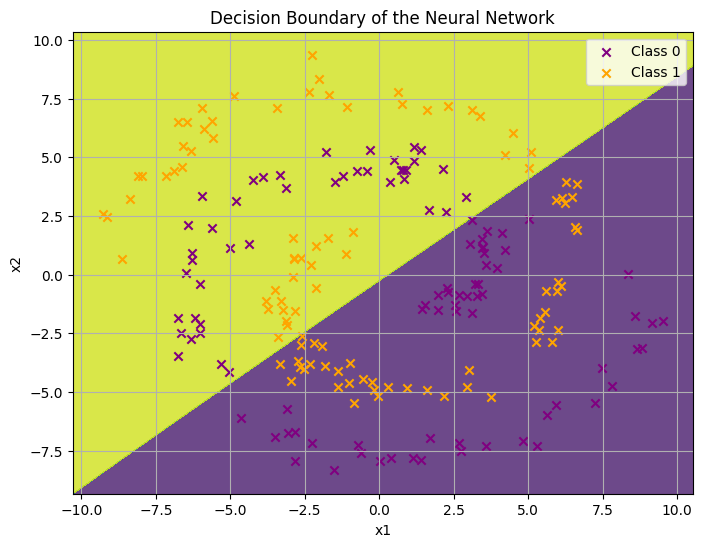

In [25]:
# We now want to print the desicion boundary of the network.
import matplotlib.pyplot as plt
import numpy as np
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    with torch.no_grad():
        grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
        outputs = model(grid)
        _, predicted = torch.max(outputs.data, 1)
    
    Z = predicted.cpu().numpy().reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='purple', label='Class 0', marker='x')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='orange', label='Class 1', marker='x')
    plt.title('Decision Boundary of the Neural Network')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid()
    plt.show()
# Plot the decision boundary
plot_decision_boundary(spiral_nn, X, y) 

In [10]:
#

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Old Stuff

In [11]:
# Design a simple neural network
class SpiralNN(nn.Module):
    def __init__(self):
        super(SpiralNN, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# Define without torch.nn: 
# input size, hidden size, and output size
input_size = 2
hidden_size = 4
output_size = 1

# Initialize weights and biases
W1 = torch.randn(input_size, hidden_size, requires_grad=True)   # Input to hidden weights
b1 = torch.randn(hidden_size, requires_grad=True)               # Hidden layer bias
W2 = torch.randn(hidden_size, output_size, requires_grad=True)  # Hidden to output weights
b2 = torch.randn(output_size, requires_grad=True)               # Output layer bias

# Forward pass function
def forward(x):
    # Hidden layer computation
    hidden = torch.matmul(x, W1) + b1  # Linear transformation
    hidden = torch.relu(hidden)        # Activation function
    
    # Output layer computation
    output = torch.matmul(hidden, W2) + b2
    return output

# Example input
x = torch.tensor([[1.0, 2.0]])  # Batch of 1 input with 2 features
y = forward(x)
print("Output without torch.nn:", y)

Output without torch.nn: tensor([[0.8201]], grad_fn=<AddBackward0>)


In [13]:
# Define the neural network using torch.nn.Module
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(2, 4)  # Input to hidden layer
        self.output = nn.Linear(4, 1)  # Hidden to output layer
    
    def forward(self, x):
        x = torch.si(self.hidden(x))  # Hidden layer with ReLU activation
        x = self.output(x)              # Output layer
        return x

# Initialize the model
model = SimpleNN()

# Example input
x = torch.tensor([[1.0, 2.0]])
y = model(x)
print("Output with torch.nn:", y)

AttributeError: module 'torch' has no attribute 'si'

### In Pytorch torch.nn are multiple layer-Options:

1. ##### nn.Linear: Fully Connected Layer
Purpose: Applies a linear transformation: y = xW^T + b
    Common Use: Used in feedforward networks for dense connections between layers.

In [ ]:
# Buld a simple neural network
class SpiralModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
# Initialize the model
model = SpiralModel().to(device)

# Using the training data
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
# Forward pass through the model
logits = model(X_tensor)
# Apply softmax to get probabilities
pred_probab = nn.Softmax(dim=1)(logits)
# Get the predicted class
y_pred = pred_probab.argmax(1)
# Print the predicted class
print(f"Predicted class: {y_pred.cpu().numpy()}")
# Print the model architecture
print(model)
# Print the model parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")



Predicted class: [1]
SpiralModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)
linear_relu_stack.0.weight: torch.Size([512, 2])
linear_relu_stack.0.bias: torch.Size([512])
linear_relu_stack.2.weight: torch.Size([512, 512])
linear_relu_stack.2.bias: torch.Size([512])
linear_relu_stack.4.weight: torch.Size([512, 512])
linear_relu_stack.4.bias: torch.Size([512])
linear_relu_stack.6.weight: torch.Size([2, 512])
linear_relu_stack.6.bias: torch.Size([2])


/var/folders/nx/kg85m7c16_5b92qvl57_h0d40000gn/T/ipykernel_62475/3619146139.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).to(device)


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [ ]:
X = torch.rand(1, 2, 1, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([1], device='mps:0')


### Ideen und weitere Möglichkeiten:

1. Interaktive Oberfläche zur Anpassung der Hyperparamenter
2. Visualisierung der Neuronalen-Netze wie auf der Website
3. Loss anzeigen über die Itterationen des Trainings